In [1]:
!pip install vllm --quiet
!pip install ray --quiet

In [2]:
from vllm import LLM, SamplingParams
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ray
import csv

### Dataset and Exploratory analysis

In [3]:
df = pd.read_csv('/content/research-paper-classifications.csv')

In [4]:
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
df.describe()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
count,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000
mean,10486.500000,0.409784,0.286716,0.267881,0.248236,0.027990,0.011873
std,6054.239259,0.491806,0.452238,0.442866,0.432000,0.164947,0.108317
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5243.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10486.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15729.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,20972.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [32]:
df = df[:10000]

<ipython-input-33-5d8d01913d38>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


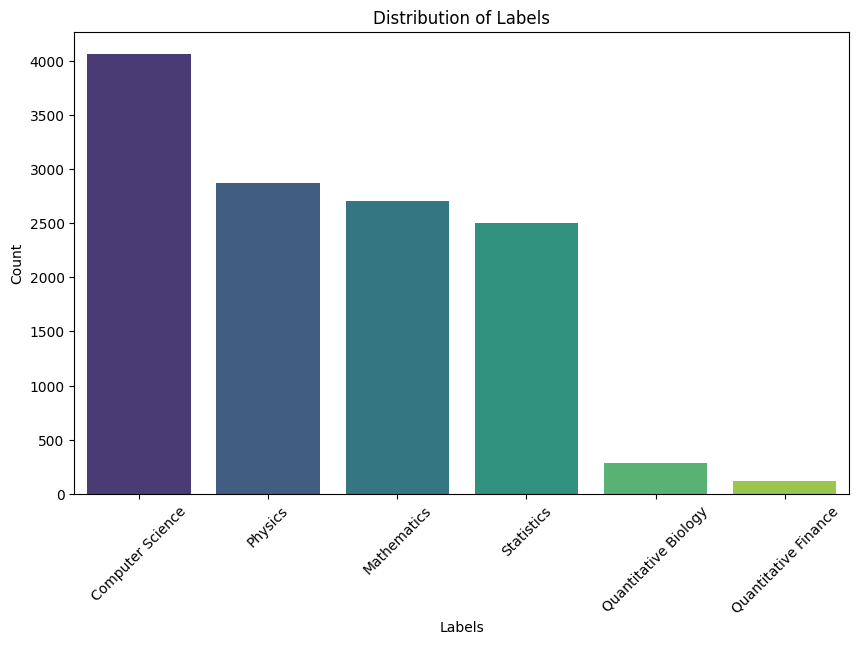

In [33]:
label_cols = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
label_counts = df[label_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

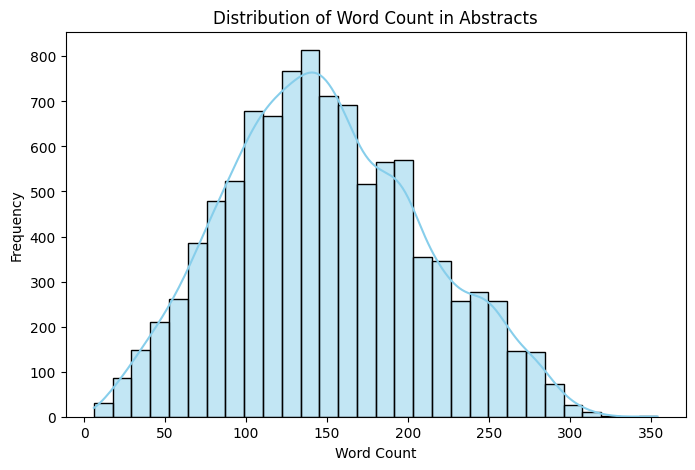

In [34]:
df['abstract_word_count'] = df['ABSTRACT'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 5))
sns.histplot(df['abstract_word_count'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Word Count in Abstracts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

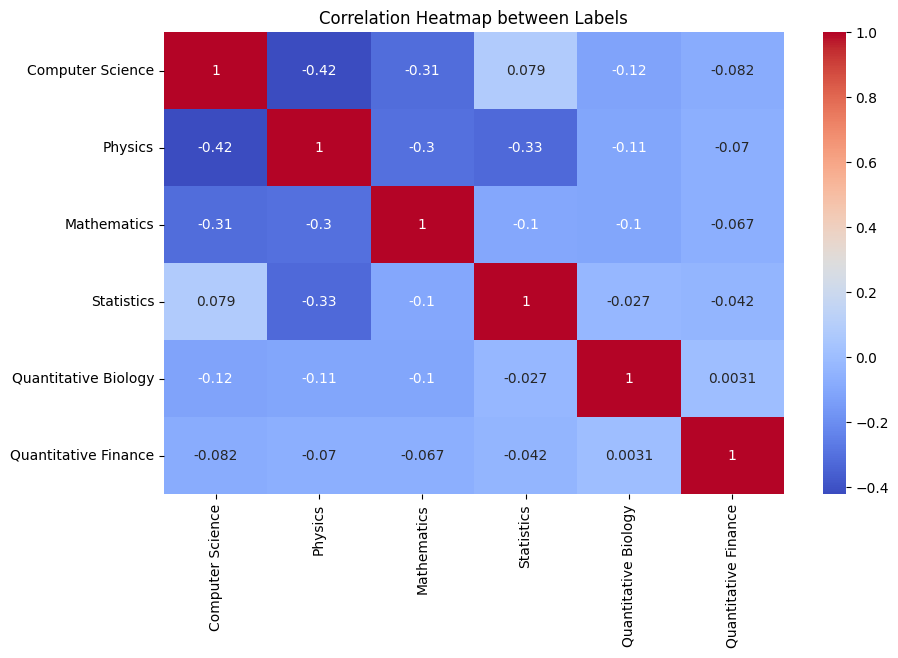

In [35]:
plt.figure(figsize=(10, 6))
label_corr = df[label_cols].corr()
sns.heatmap(label_corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap between Labels")
plt.show()

### Prompt Engineering

In [10]:
prompts = []

for index, row in df.iterrows():
  title = row["TITLE"]
  abstract = row["ABSTRACT"]

  prompts.append(f"""
  You are an expert in analyzing research papers and comprehending the respective title and abstract of the papers. Each of the paper
  has to be classified into a subject category. The categories are: [Computer Science, Physics, Mathematics, Statistics,
  Quantitative Biology, Quantitative Finance]. Your task is to classify the papers into one of the above categories. If a paper has
  content belonging to two categories, classify accordingly. Do not hallucinate and strictly do not give explanations for classification.

  Follow the below examples for classification and give output in the similar format.

  Instruct:
  Title: 'Rotation Invariance Neural Network'
  Abstract: 'Rotation invariance and translation invariance have great values in image recognition tasks'

  Output:
  Computer Science

  Instruct:
  Title: 'A finite element approximation for the stochastic Maxwell--Landau--Lifshitz--Gilbert system'
  Abstract: 'The stochastic Landau--Lifshitz--Gilbert (LLG) equation coupled with the Maxwell equations forms amazing results'

  Output:
  Mathematics

  Instruct:
  Title: {title}
  Abstract: {abstract}

  Output:
  """)

In [11]:
prompts = prompts[:5000]

### Initialize Ray and vLLM

In [12]:
ray.shutdown()
ray.init()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-12 09:14:47,984	INFO worker.py:1749 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.21.0


In [13]:
sampling_params = SamplingParams(temperature=0.5, top_p=0.95)

In [14]:
mistral = LLM(model="TheBloke/Mistral-7B-Instruct-v0.1-GPTQ",
          dtype='half',
          quantization='GPTQ',
          gpu_memory_utilization=0.7,
          enforce_eager=True,
          max_model_len=6000)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

WARNING 05-12 09:14:53 config.py:1086] Casting torch.bfloat16 to torch.float16.
WARNING 05-12 09:14:53 config.py:205] gptq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 05-12 09:14:53 llm_engine.py:100] Initializing an LLM engine (v0.4.2) with config: model='TheBloke/Mistral-7B-Instruct-v0.1-GPTQ', speculative_config=None, tokenizer='TheBloke/Mistral-7B-Instruct-v0.1-GPTQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=6000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=gptq, enforce_eager=True, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=TheBloke/Mistral-7B-Instruct-v0.1-GPTQ)


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

INFO 05-12 09:14:55 utils.py:660] Found nccl from library /root/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 05-12 09:14:56 selector.py:69] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 05-12 09:14:56 selector.py:32] Using XFormers backend.
INFO 05-12 09:15:01 weight_utils.py:199] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

INFO 05-12 09:15:53 model_runner.py:175] Loading model weights took 3.8845 GB
INFO 05-12 09:15:57 gpu_executor.py:114] # GPU blocks: 2138, # CPU blocks: 2048


### Output - Label Classification

In [15]:
mistral_output = mistral.generate(prompts, sampling_params)

Processed prompts: 100%|██████████| 5000/5000 [35:17<00:00,  2.36it/s]


In [16]:
generated_text = []

for output in mistral_output:
    prompt = output.prompt
    generated_text.append(output.outputs[0].text)

In [17]:
llm_mistral = pd.DataFrame(generated_text, columns=['data'])

In [18]:
def process_string(s):
    try:
        if pd.isna(s):
            return s
        else:
            return str(s).split('\n', 1)[0]
    except AttributeError:  # Handle None values
        return s

In [19]:
llm_mistral['data'] = llm_mistral['data'].apply(process_string)

In [28]:
llm_mistral.head(5)

,data
0,Mathematics
1,Computer Science
2,Mathematics
3,Mathematics
4,Quantitative Biology
